In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
%matplotlib inline



#### IMPORTANDO O DF ALIMENTAÇÃO

In [95]:
df_perifericos = pd.read_csv('../data/dados_para_processamento/df_perifericos.csv', sep =',',
                              parse_dates = ['ds'],
                              encoding = 'utf-8')
#df_alimentacao = df_alimentacao[df_alimentacao['Data_Venda'] != '2020-01']

In [96]:
df_perifericos

,Produto,y,ds
0,Fone de Ouvido Sem Fio,2,2019-01-01
1,Fone de Ouvido Sem Fio,1,2019-01-01
2,Fone de Ouvido Esportivo Bose,1,2019-01-01
3,Apple Airpods,1,2019-01-01
4,Apple Airpods,1,2019-01-01
...,...,...,...
47751,Apple Airpods,1,2019-12-01
47752,Apple Airpods,1,2019-12-01
47753,Fone de Ouvido Esportivo Bose,1,2019-12-01
47754,Fone de Ouvido Sem Fio,1,2019-12-01


In [97]:
df_perifericos = df_perifericos[df_perifericos.ds != '2020-01-01'].sort_index(ascending= True)

In [98]:
df_perifericos

,Produto,y,ds
0,Fone de Ouvido Sem Fio,2,2019-01-01
1,Fone de Ouvido Sem Fio,1,2019-01-01
2,Fone de Ouvido Esportivo Bose,1,2019-01-01
3,Apple Airpods,1,2019-01-01
4,Apple Airpods,1,2019-01-01
...,...,...,...
47751,Apple Airpods,1,2019-12-01
47752,Apple Airpods,1,2019-12-01
47753,Fone de Ouvido Esportivo Bose,1,2019-12-01
47754,Fone de Ouvido Sem Fio,1,2019-12-01


In [99]:
df_perifericos.info(10)

<class 'pandas.core.frame.DataFrame'>
Index: 47748 entries, 0 to 47755
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Produto  47748 non-null  object        
 1   y        47748 non-null  int64         
 2   ds       47748 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.5+ MB


In [100]:
df_perifericos.head(8)

,Produto,y,ds
0,Fone de Ouvido Sem Fio,2,2019-01-01
1,Fone de Ouvido Sem Fio,1,2019-01-01
2,Fone de Ouvido Esportivo Bose,1,2019-01-01
3,Apple Airpods,1,2019-01-01
4,Apple Airpods,1,2019-01-01
5,Apple Airpods,1,2019-01-01
6,Apple Airpods,1,2019-01-01
7,Fone de Ouvido Esportivo Bose,1,2019-01-01


In [101]:
df_perifericos_2 = df_perifericos.groupby(['ds', 'Produto'])["y"].sum().reset_index()

In [102]:
df_perifericos_2.head(10)

,ds,Produto,y
0,2019-01-01,Apple Airpods,814
1,2019-01-01,Fone de Ouvido Esportivo Bose,659
2,2019-01-01,Fone de Ouvido Sem Fio,1081
3,2019-02-01,Apple Airpods,1012
4,2019-02-01,Fone de Ouvido Esportivo Bose,841
5,2019-02-01,Fone de Ouvido Sem Fio,1279
6,2019-03-01,Apple Airpods,1322
7,2019-03-01,Fone de Ouvido Esportivo Bose,1198
8,2019-03-01,Fone de Ouvido Sem Fio,1664
9,2019-04-01,Apple Airpods,1519


In [103]:
df_perifericos_2.Produto.nunique()

3

In [104]:
df_perifericos_2.columns

Index(['ds', 'Produto', 'y'], dtype='object')

In [111]:
def preparaDF(df, list_alimentacao):
    num_plots = len(list_alimentacao)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols  # Arredonda para cima a divisão

    fig, axs = plt.subplots(1, num_cols, figsize=(15, 6))

    for i, produto in enumerate(list_alimentacao):
        novo_df = df[df['Produto'] == produto]
        novo_df = novo_df.drop(columns={'Produto'})
        novo_df = novo_df.set_index('ds')['y']
        novo_df = novo_df.asfreq('MS')

        # ARIMA
        model_arima = ARIMA(novo_df, order=(0, 1, 2))
        fit_arima = model_arima.fit()

        forecast_arima = fit_arima.forecast(steps=2)

        sns.set_palette("OrRd")

        col = i % num_cols

        axs[col].plot(novo_df.index, novo_df.values, label='Dados reais', marker='o')
        axs[col].plot(forecast_arima.index, forecast_arima.values, color='red', linestyle='--', label='Previsões ARIMA', marker='o', markersize=8)
        axs[col].grid(True, which='both', linestyle='--', linewidth=0.3)
        axs[col].plot([novo_df.index[-1], forecast_arima.index[0]], [novo_df.values[-1], forecast_arima.values[0]], color='red', linestyle='--')

        axs[col].set_xlabel('Mês')
        axs[col].set_ylabel('Quantitativo de Vendas')
        axs[col].set_title(f'Previsão de Vendas - {produto}', y=1.05)
        axs[col].legend()
        axs[col].set_xticks(pd.date_range(start=novo_df.index[0], end=forecast_arima.index[-1], freq='MS'))
        
        axs[col].tick_params(axis='x', rotation=45, colors='gray') # Definindo cor cinza para os ticks do eixo x
        axs[col].tick_params(axis='y', colors='gray') # Definindo cor 

        axs[col].spines['right'].set_visible(False)
        axs[col].spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()

c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


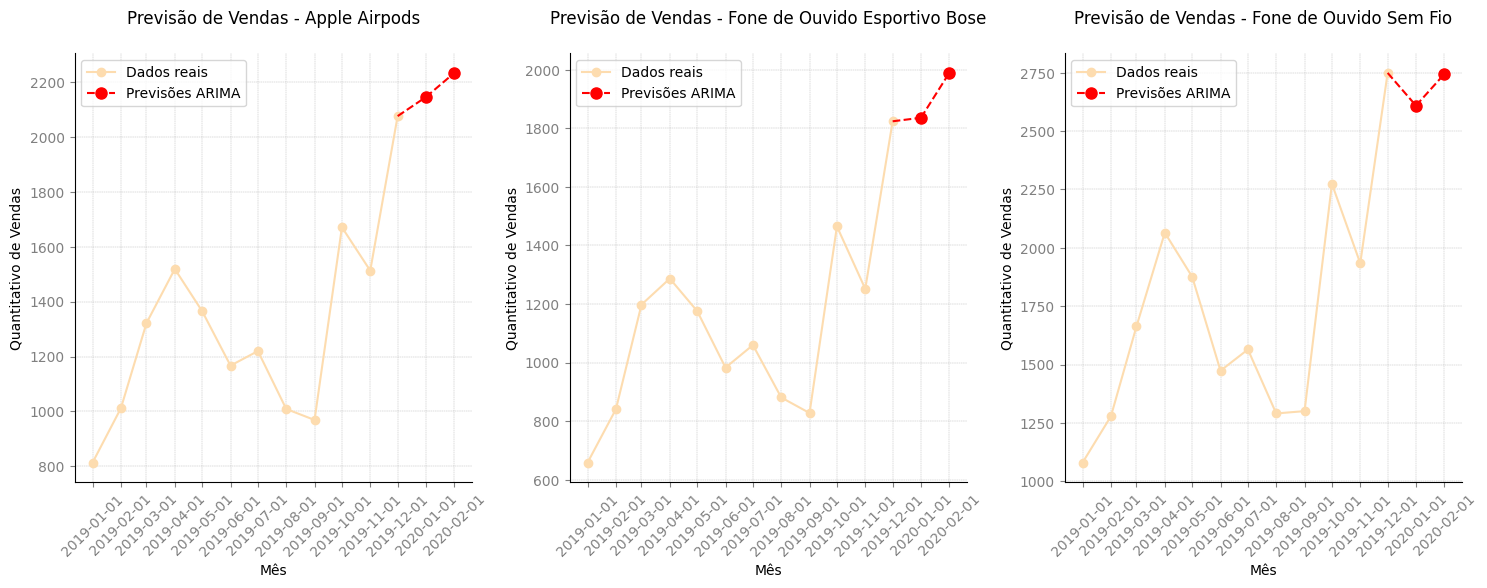

In [112]:
list_alimentacao = df_perifericos_2['Produto'].unique()

sns.set_palette("OrRd", 4)

preparaDF(df_perifericos_2, list_alimentacao)